In [24]:
import boto3, botocore
import logging
import os
import sys, getopt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

# Retrieve the list of existing buckets
BUCKET_NAME = "streamscope"

s3 = boto3.client('s3', endpoint_url="https://s3-west.nrp-nautilus.io")

ROOT_DIR = ""

result = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=ROOT_DIR, Delimiter='/')

dir_list = []

for o in result.get('CommonPrefixes'):
    path = o.get('Prefix')
    if path == "/":
        continue
    dir_list.append(path.replace("/", ""))
    
print(dir_list)

['3t3-2', 'alisal2', 'experiment_test_name', 'hunter2', 'imaging', 'nicousf', 'test-experiment']


In [35]:
import base64

BUCKET_NAME = "streamscope"

s3 = boto3.client('s3', endpoint_url="https://s3-west.nrp-nautilus.io")

ROOT_DIR = ""

experiment_name = "imaging/hunter1"

cam_name = "cam4_DMEM"

page_size = 1000

prefix = ROOT_DIR + experiment_name + "/" + cam_name+"/"

max_images_per_page = page_size

cur_img_index = 0

# paginator = s3.get_paginator("list_objects_v2")
# response = paginator.paginate(Bucket=BUCKET_NAME, PaginationConfig={"PageSize": max_images_per_page, "Prefix": prefix+chosen_cam+"/"})
# for page in response:
#     print("getting 2 files from S3")
#     files = page.get("Contents")
#     for file in files:
#         print(f"file_name: {file['Key']}, size: {file['Size']}")
#     print("#" * 10)

response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=prefix, Delimiter='/')

file_list = []

# TODO: Use this for more than 1,000 files in the subdirectory
# s3 = boto3.resource('s3')
# bucket = s3.Bucket('mybucket')
# prefix="subfolder1/sub_subfolder1/....."
# for object_summary in bucket.objects.filter(Prefix=prefix):
#     print(object_summary.key)

# TODO: Ensure that only images are counted.
for content in response.get('Contents', []):
    path = content['Key']
    if path == "/":
        continue
    file_list.append(path)
    #print(path)

file_list = sorted(file_list, key=lambda x: int(x.split(prefix)[1].replace("/", "").split("_")[1].split(".")[0]))

max_file_index = int(file_list[-1].split(prefix)[1].replace("/", "").split("_")[1].split(".")[0])

images = []
file_names = []

print("Len file list:", len(file_list), " max index:", max_file_index)

file_dict = {}

for file in file_list:
    file_dict[int(file.split(prefix)[1].replace("/", "").split("_")[1].split(".")[0])] = file

#print("file_dict:", file_dict)

#print("Sorted file_list:", file_list)

print("cur_img_index before:", cur_img_index)
if max_file_index <= cur_img_index+max_images_per_page:
    cur_img_index = max_file_index-max_images_per_page

print("cur_img_index after:", cur_img_index, " cur_img_index + page size:", cur_img_index + max_images_per_page)
for i in range(cur_img_index, max_images_per_page+cur_img_index):
    if i not in file_dict:
        # TODO: Consider the case of a discontinuity, such as having page size of 5 and indices 100, 101, 102, 103, 107. You'd return only four results even though five exist.
        continue
    #print("in here")
    path = file_dict[i]

    file_names.append(path.split(prefix)[1].replace("/", "").split("_")[1].split(".")[0])

    try:
        s3_response_object = s3.get_object(Bucket=BUCKET_NAME, Key=path)
        object_content = s3_response_object['Body'].read()
        images.append(base64.b64encode(BytesIO(object_content).getvalue()).decode('utf-8'))
    except Exception as e:
        print(e)
        
create_timelapse(np.array([np.asarray(bytearray(base64.b64decode(image)), dtype="uint8") for image in images]), 10)

Len file list: 1000  max index: 1899
cur_img_index before: 0
cur_img_index after: 0  cur_img_index + page size: 1000


In [30]:
import cv2
def create_timelapse(image_files, fps=30):
    local_path = "timelapse.mp4"
    frame = cv2.imdecode(image_files[0], cv2.IMREAD_COLOR)
    height, width, layers = frame.shape
    #cv2.imwrite("result.jpg", frame)

    #print("image_files:", image_files)

    # Determine common size for all images
    # TODO: Should probably eliminate this
    for image_file in image_files:
        image = cv2.imdecode(image_file, cv2.IMREAD_COLOR)
        if image.shape != (height, width, layers):
            height, width, layers = image.shape

    # Create video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(local_path, fourcc, fps, (width, height))

    # Write frames to video
    for image_file in image_files:
        image = cv2.imdecode(image_file, cv2.IMREAD_COLOR)

        # Resize image if necessary
        if image.shape != (height, width, layers):
            image = cv2.resize(image, (width, height))

        video.write(image)

    # Release resources
    cv2.destroyAllWindows()
    video.release()
    contents = None
    with open(local_path, mode="rb") as video_file:
        contents = video_file.read()
    #return base64.b64encode(BytesIO(contents).getvalue()).decode('utf-8') 
    
#create_timelapse(np.array([np.asarray(bytearray(base64.b64decode(image)), dtype="uint8") for image in images]), 10)

In [2]:
import boto3, botocore
import logging
import os
import sys, getopt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

# Retrieve the list of existing buckets
BUCKET_NAME = "streamscope"

s3 = boto3.client('s3', endpoint_url="https://s3-west.nrp-nautilus.io")

ROOT_DIR = "/"

experiment_name = "alisal2" + "/"

prefix = ROOT_DIR + experiment_name

max_images_per_page = 10

print(prefix)

result = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=prefix, Delimiter='/')

camera_dir_list = []

cam_names = []

for o in result.get('CommonPrefixes'):
    path = o.get('Prefix')
    camera_dir_list.append(path)
    cam_names.append(path.split(prefix)[1].replace("/", ""))
    
print(camera_dir_list)
print(cam_names)

chosen_cam = "cam0"

file_name = ""

print(prefix+chosen_cam+"/")
    
# paginator = s3.get_paginator("list_objects_v2")
# response = paginator.paginate(Bucket=BUCKET_NAME, PaginationConfig={"PageSize": max_images_per_page, "Prefix": prefix+chosen_cam+"/"})
# for page in response:
#     print("getting 2 files from S3")
#     files = page.get("Contents")
#     for file in files:
#         print(f"file_name: {file['Key']}, size: {file['Size']}")
#     print("#" * 10)
    
response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=prefix+chosen_cam+"/", Delimiter='/')

camera_dir_list = []

cam_names = []

file_list = []

# TODO: Use this for more than 1,000 files in the subdirectory
# s3 = boto3.resource('s3')
# bucket = s3.Bucket('mybucket')
# prefix="subfolder1/sub_subfolder1/....."
# for object_summary in bucket.objects.filter(Prefix=prefix):
#     print(object_summary.key)

for content in response.get('Contents', []):
    path = content['Key']
    file_list.append(path)
    print(path)
    
last_i = 0
    
images = []
    
for i in range(0, max_images_per_page):
    if i == len(file_list):
        break
    last_i = i
    path = file_list[i]
    
    try:
        s3_response_object = s3.get_object(Bucket=BUCKET_NAME, Key=path)
        object_content = s3_response_object['Body'].read()
        images.append(Image.open(BytesIO(object_content)))
    except Exception as e:
        print(e)
        raise

/alisal2/


TypeError: 'NoneType' object is not iterable

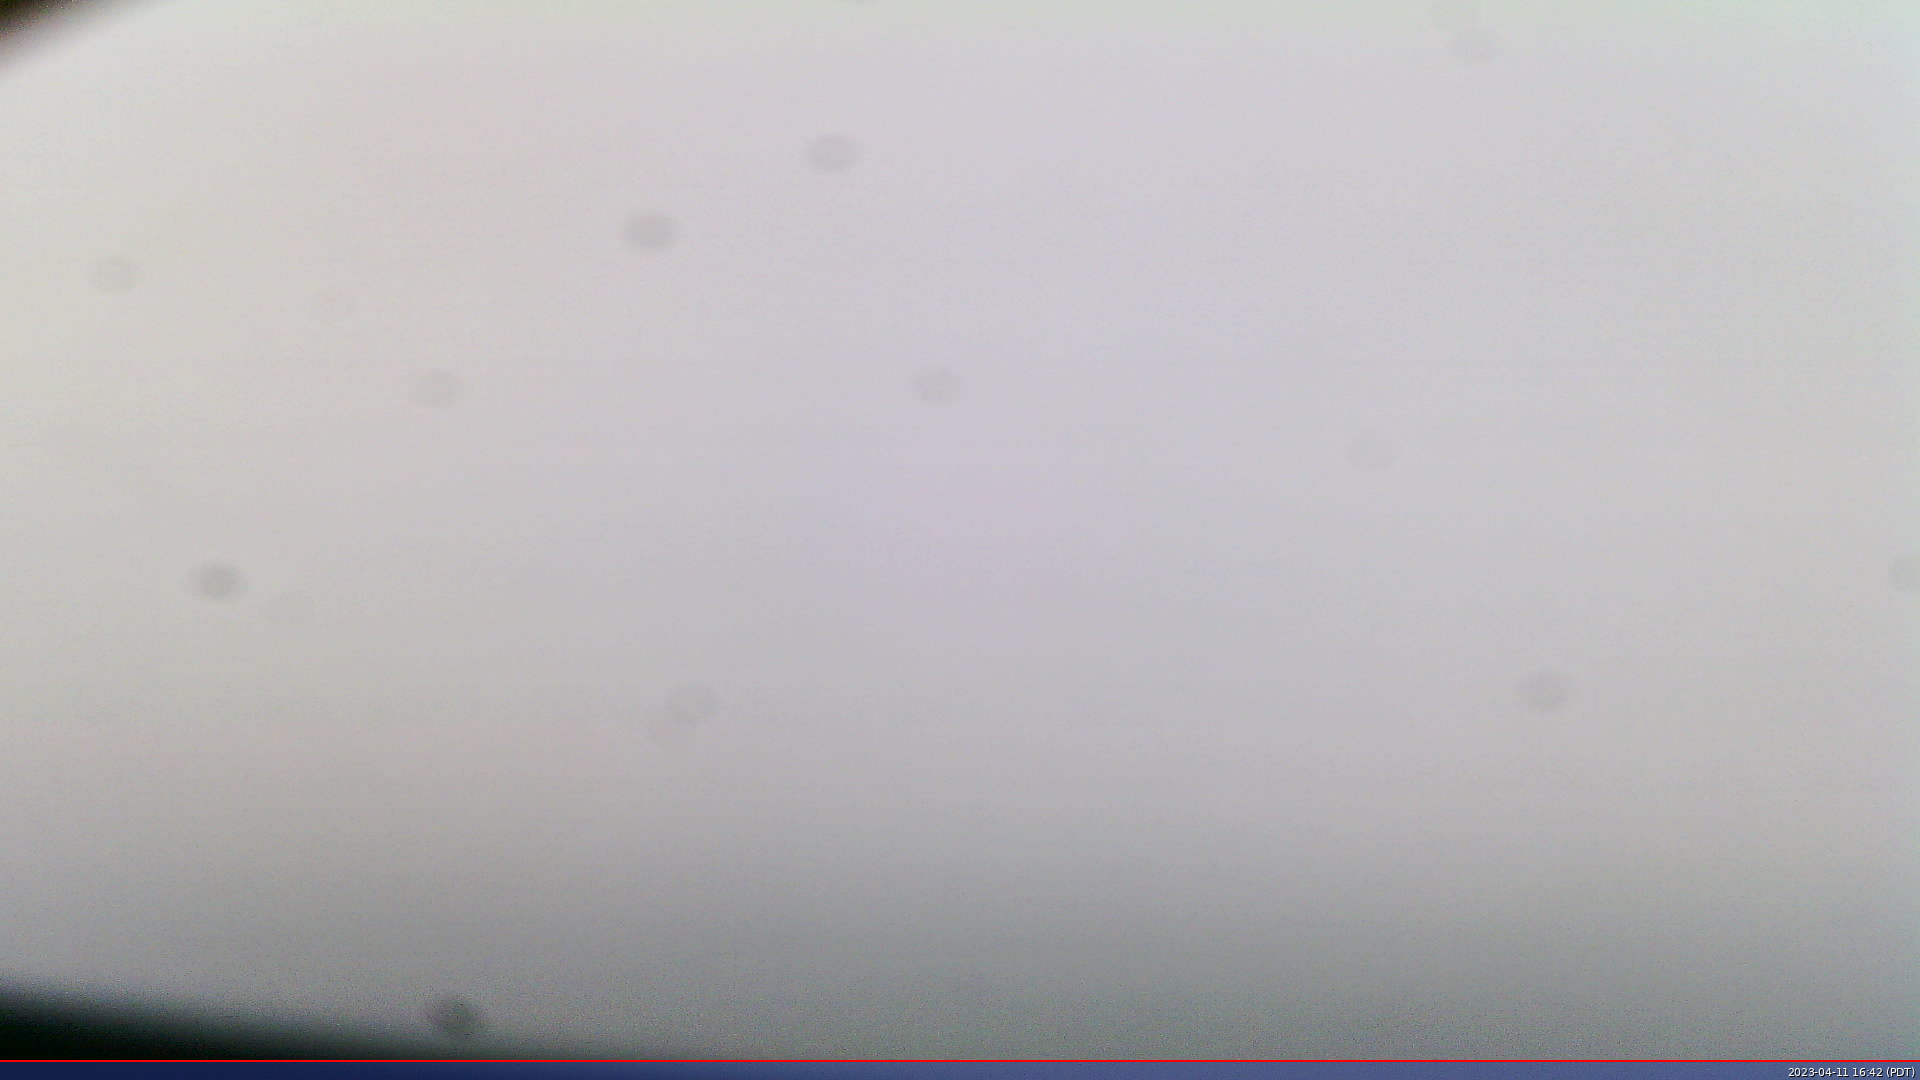

In [9]:
from IPython.display import display

display(images[1])

In [11]:
import json
from flask import Flask, request, jsonify, render_template
import cv2
from flask import make_response, send_file
import base64

import boto3, botocore
import logging
import os
import sys, getopt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO


app = Flask(__name__)

@app.route('/', methods=['GET'])
def get_frames():
    # cap = cv2.VideoCapture(0)
    #
    # # Check if the webcam is opened correctly
    # if not cap.isOpened():
    #     raise IOError("Cannot open webcam")
    #
    # ret, frame = cap.read()
    # frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    #
    # cap.release()
    # cv2.destroyAllWindows()
    #frame = cv2.imread('image.png')
    #retval, buffer = cv2.imencode('.png', frame)

    # Retrieve the list of existing buckets
    BUCKET_NAME = "braingeneers"

    s3 = boto3.client('s3', endpoint_url="https://s3-west.nrp-nautilus.io")

    ROOT_DIR = "imaging/streamscope/"

    experiment_name = "nicousf" + "/"

    prefix = ROOT_DIR + experiment_name

    max_images_per_page = 10

    print(prefix)

    result = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=prefix, Delimiter='/')

    camera_dir_list = []

    cam_names = []

    for o in result.get('CommonPrefixes'):
        path = o.get('Prefix')
        camera_dir_list.append(path)
        cam_names.append(path.split(prefix)[1].replace("/", ""))

    print(camera_dir_list)
    print(cam_names)

    chosen_cam = "cam0"

    file_name = ""

    print(prefix+chosen_cam+"/")

    # paginator = s3.get_paginator("list_objects_v2")
    # response = paginator.paginate(Bucket=BUCKET_NAME, PaginationConfig={"PageSize": max_images_per_page, "Prefix": prefix+chosen_cam+"/"})
    # for page in response:
    #     print("getting 2 files from S3")
    #     files = page.get("Contents")
    #     for file in files:
    #         print(f"file_name: {file['Key']}, size: {file['Size']}")
    #     print("#" * 10)

    response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=prefix+chosen_cam+"/", Delimiter='/')

    camera_dir_list = []

    cam_names = []

    file_list = []

    # TODO: Use this for more than 1,000 files in the subdirectory
    # s3 = boto3.resource('s3')
    # bucket = s3.Bucket('mybucket')
    # prefix="subfolder1/sub_subfolder1/....."
    # for object_summary in bucket.objects.filter(Prefix=prefix):
    #     print(object_summary.key)

    for content in response.get('Contents', []):
        path = content['Key']
        file_list.append(path)
        print(path)

    last_i = 0

    images = []

    for i in range(0, max_images_per_page):
        if i == len(file_list):
            break
        last_i = i
        path = file_list[i]

        try:
            s3_response_object = s3.get_object(Bucket=BUCKET_NAME, Key=path)
            object_content = s3_response_object['Body'].read()
            images.append(base64.b64encode(BytesIO(object_content).getvalue()).decode('utf-8'))
        except Exception as e:
            print(e)
            raise
#     ocvim = cv2.cvtColor(np.array(images[0]), cv2.COLOR_RGB2BGR)
#     retval, buffer = cv2.imencode('.png', ocvim)
#     response = make_response(buffer.tobytes())
#     response.headers.set('Content-Type', 'image/png')
#     return response

    return render_template("index.html", imagelist=images)
    #return render_template("index.html", imagelist=buffer.tobytes())

@app.route('/', methods=['PUT'])
def create_record():
    record = json.loads(request.data)
    with open('/tmp/data.txt', 'r') as f:
        data = f.read()
    if not data:
        records = [record]
    else:
        records = json.loads(data)
        records.append(record)
    with open('/tmp/data.txt', 'w') as f:
        f.write(json.dumps(records, indent=2))
    return jsonify(record)

@app.route('/', methods=['POST'])
def update_record():
    record = json.loads(request.data)
    new_records = []
    with open('/tmp/data.txt', 'r') as f:
        data = f.read()
        records = json.loads(data)
    for r in records:
        if r['name'] == record['name']:
            r['email'] = record['email']
        new_records.append(r)
    with open('/tmp/data.txt', 'w') as f:
        f.write(json.dumps(new_records, indent=2))
    return jsonify(record)

@app.route('/', methods=['DELETE'])
def delte_record():
    record = json.loads(request.data)
    new_records = []
    with open('/tmp/data.txt', 'r') as f:
        data = f.read()
        records = json.loads(data)
        for r in records:
            if r['name'] == record['name']:
                continue
            new_records.append(r)
    with open('/tmp/data.txt', 'w') as f:
        f.write(json.dumps(new_records, indent=2))
    return jsonify(record)

app.run(host="127.0.0.1", port=5124, debug=True)
# response = requests.get('http://127.0.0.1:5555/')
# response.text

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 88, in inner
    return method(app, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 632, in initialize
    self.init_sockets()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 282, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 229, in _bind_socket
    return self._try_bind_socket(s, port)
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 205, in _try_bind_socket
    s

SystemExit: 1